# Anomaly detection

This is an attempt to perform [anomaly detection][] on contract data. In particular, many prices in the contract data seem to reflect _daily_ (or perhaps even weekly or monthly) rates rather than _hourly_ rates, and this is an attempt to find them (though we might find other anomalies in the process too).

Note that unlike other notebooks in this repository, this one requires Anaconda and runs on Python 3.6.

[anomaly detection]: https://www.coursera.org/learn/machine-learning/lecture/V9MNG/problem-motivation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

%matplotlib inline

## Load hourly price data

In [2]:
hourly_prices = pd.read_csv('../data/hourly_prices.csv', index_col=False, thousands=',', usecols=[
    'Labor Category',
    'CurrentYearPricing',
    'Education',
    'MinExpAct',
    'Schedule',
    'CONTRACT .',
    'COMPANY NAME',
])

hourly_prices.rename(columns={
    'Labor Category': 'name',
    'CurrentYearPricing': 'price',
    'Education': 'edu',
    'MinExpAct': 'minxp',
    'Schedule': 'schedule',
    'CONTRACT .': 'contract',
    'COMPANY NAME': 'company',
}, inplace=True)

print(f"Loaded {hourly_prices.shape[0]} rows.")

# Show some example rows, just so we can get an idea of the shape of the data.
hourly_prices[:3]

Loaded 54610 rows.


,name,edu,minxp,company,contract,schedule,price
0,Project Manager,Bachelors,8.0,"SSG-Advisors, LLC",GS-10F-0274S,MOBIS,1013.38
1,Program Coordinator,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,992.56
2,"Interpretation Services Class 4: Afrikan,Akan,...",NaN,2.0,"Transperfect Translations International, Inc.",GS-10F-0076S,Language Services,992.00


## Remove incomplete/invalid data

Some of this data is actually in CALC, but for the purposes of this analysis, we're going to throw out the following:

* Rows with any columns that aren't filled out (i.e., whose values are `NaN`).
* Rows with an invalid education field.

In [3]:
HIGH_SCHOOL = 'High School'
ASSOCIATES = 'Associates'
BACHELORS = 'Bachelors'
MASTERS = 'Masters'
PHD = 'Ph.D.'

EDU_LEVELS = [HIGH_SCHOOL, ASSOCIATES, BACHELORS, MASTERS, PHD]

def one_of(series, values):
    """
    Returns a series of booleans that is True when the
    corresponding item in the given series has a valid
    value.
    """

    result = False
    for value in values:
        result = result | (series == value)
    return result

hourly_prices.dropna(axis=0, how='any', inplace=True)

hourly_prices = hourly_prices[one_of(hourly_prices['edu'], EDU_LEVELS)]

print(f"Culled rows with incomplete/invalid data, leaving {hourly_prices.shape[0]} rows.")

Culled rows with incomplete/invalid data, leaving 48569 rows.


## Bin experience into buckets

For reasons that will make more sense soon, we're going to define "buckets" of minimum experience:

* Bucket 0: 0-4 minimum years of experience
* Bucket 1: 5-9 minimum years of experience
* Bucket 2: 10-14 minimum years of experience
* Bucket 3: 15-19 minimum years of experience
* Bucket 4: 20+ minimum years of experience

In [4]:
MAX_XP = 20.0

XP_BUCKET_SIZE = 5

NUM_XP_BUCKETS = int(MAX_XP / XP_BUCKET_SIZE + 1)

hourly_prices['xp_bucket'] = (hourly_prices.minxp.clip(upper=MAX_XP) / XP_BUCKET_SIZE).astype(int)

Let's see what our data looks like so far:

In [5]:
hourly_prices[:3]

,name,edu,minxp,company,contract,schedule,price,xp_bucket
0,Project Manager,Bachelors,8.0,"SSG-Advisors, LLC",GS-10F-0274S,MOBIS,1013.38,1
1,Program Coordinator,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,992.56,0
3,Administrative Support,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,981.44,0


## Make it easy to slice and dice the data

Here we'll add a `filtr` function (the name `filter` is taken) to make it easy to filter through the data any way we want.

In [6]:
def filtr(edu=None, xp_bucket=None, minxp=None, schedule=None):
    r = hourly_prices
    if edu is not None:
        r = r[r.edu == edu]
        if r.empty:
            raise ValueError(f"invalid edu: {edu}")
    if xp_bucket is not None:
        if xp_bucket < 0 or xp_bucket >= NUM_XP_BUCKETS:
            raise ValueError(f"invalid xp_bucket: {xp_bucket}")
        r = r[r.xp_bucket == xp_bucket]
    if minxp is not None:
        r = r[r.minxp >= minxp]
    if schedule is not None:
        r = r[r.schedule == schedule]
        if r.empty:
            raise ValueError(f"invalid schedule: {schedule}")
    return r


## Transform price data

Our existing price distribution is kind of lopsided because most labor categories have low prices.  As per Andrew Ng's suggestion in his [lecture on choosing what features to use](https://www.coursera.org/learn/machine-learning/lecture/LSpXm/choosing-what-features-to-use), we'll transform the price data to have a more normal distribution.

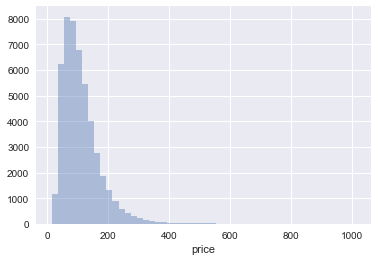

In [7]:
sns.distplot(hourly_prices.price, kde=False)

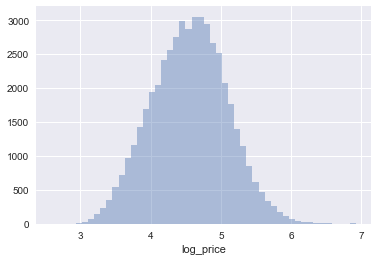

In [8]:
hourly_prices['log_price'] = np.log(hourly_prices.price)

sns.distplot(hourly_prices.log_price, kde=False)

## Define density estimation parameters

Because prices are clearly influenced by the level of education and number of years of experience, we're going to calculate our mean and variance based on each education level / experience bucket combination. Whether something is an anomaly will then depend on what its price is relative to the particular education level / experience bucket combination it's in.

We'll do this using a pandas [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/advanced.html).

In [9]:
edu_xp_index = pd.MultiIndex.from_product([EDU_LEVELS, range(NUM_XP_BUCKETS)], names=['edu', 'xp_bucket'])

In [10]:
def edu_xp_agg(func):
    return list(edu_xp_index.map(lambda x: filtr(edu=x[0], xp_bucket=x[1]).log_price.agg(func)))

In [11]:
edu_xp_aggs = pd.DataFrame(
    list(zip(edu_xp_agg('mean'), edu_xp_agg('std'))),
    index=edu_xp_index, columns=['mean', 'std']
)

Here's what our `edu_xp_aggs` DataFrame looks like now.  Note that only the shape is really important: the numbers won't actually mean much, since they reflect the mean/variance of our transformed prices. 

In [12]:
edu_xp_aggs[:10]

mean       std
edu         xp_bucket                    
High School 0          3.866920  0.354101
            1          4.215916  0.375981
            2          4.494704  0.394335
            3          4.741732  0.414377
            4          4.815409  0.360243
Associates  0          4.105952  0.358606
            1          4.327915  0.368082
            2          4.634396  0.402192
            3          4.781884  0.354746
            4          4.943171  0.398632

## Define Gaussian primitives

This is taken from Ng's [lecture on the Gaussian Distribution](https://www.coursera.org/learn/machine-learning/lecture/ZYAyC/gaussian-distribution).

In [13]:
def gaussian_prob(value, std, mean):
    return (1 / ((np.sqrt(2 * np.pi)) * std)) * np.exp(-np.square(value - mean) / (2 * np.square(std)))

def plot_gaussian(std, mean, start=-1, stop=1, step=0.1):
    x = np.arange(start, stop + step, step)
    return plt.plot(x, gaussian_prob(x, std, mean))

Just to make sure our gaussian works, let's draw it.

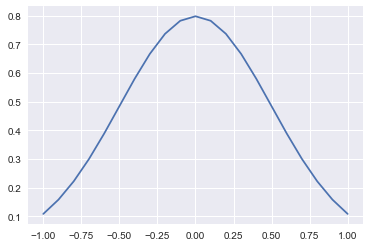

In [14]:
plot_gaussian(0.5, 0)

## Find anomalous prices

We'll combine our density estimation parameters with our hourly price data via [DataFrame.merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and use that to get probabilities for every price, as per the [lecture on the density estimation algorithm](https://www.coursera.org/learn/machine-learning/lecture/C8IJp/algorithm).

In [15]:
def probabilities():
    merged = hourly_prices.merge(edu_xp_aggs, left_on=['edu', 'xp_bucket'], right_index=True, how='left')
    return gaussian_prob(hourly_prices.log_price, merged['std'], merged['mean'])

In [16]:
epsilon = 0.01

hourly_prices['p'] = probabilities()

anomalies = hourly_prices[hourly_prices['p'] < epsilon].sort_values(by=['p'])

print(f"Found {anomalies.shape[0]} potential anomalies.")

# Show the top ten most probable anomalies.
anomalies[:10]

Found 243 potential anomalies.


,name,edu,minxp,company,contract,schedule,price,xp_bucket,log_price,p
46,Teleprompter Operator,High School,3.0,"Digital Outpost, Inc.",GS-23F-0143S,AIMS,700.00,0,6.551080,3.754533e-13
53,Audio-Sound Recordist,High School,3.0,"Ambient Light, LLC",GS-00F-212DA,Consolidated,659.10,0,6.490875,1.342768e-12
13,Producer,High School,7.0,"Ambient Light, LLC",GS-00F-212DA,Consolidated,941.58,1,6.847559,2.439674e-11
14,Video Editor,High School,7.0,"Ambient Light, LLC",GS-00F-212DA,Consolidated,910.19,1,6.813653,4.567676e-11
1,Program Coordinator,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,992.56,0,6.900287,8.653245e-11
3,Administrative Support,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,981.44,0,6.889021,1.064961e-10
15,Consultant,Bachelors,2.0,"Dalberg Consulting-U.S., LLC",GS-10F-0188V,MOBIS,906.80,0,6.809922,4.455506e-10
26,Director,High School,7.0,"Ambient Light, LLC",GS-00F-212DA,Consolidated,793.95,1,6.677020,5.265774e-10
148,Director Photography,High School,1.0,"Shatterglass Studios, LLC",GS-00F-199DA,Consolidated,478.59,0,6.170844,7.231016e-10
149,Production Manager,High School,1.0,"Shatterglass Studios, LLC",GS-00F-199DA,Consolidated,478.59,0,6.170844,7.231016e-10
